# PROCESS MINING FINAL PROJECT 2020-2021
## Train models with timestamp information
### AUTHOR: Ma Jiawei
### LECTURERS: De Leoni Massimiliano, Di Francescomarino Chiara  

Here I decided to train same models as in the case of simple encoding. For the ML models I will simply "flatten" 2-D vectors into 1-D vectors.

### Load datasets

In [1]:
import numpy as np

In [2]:
X_timestamp_train_ = np.load('X_timestamp_train.npy')
X_timestamp_train = np.load('X_timestamp_train.npy')
Y_timestamp_train = np.load('Y_timestamp_train.npy')

In [3]:
print(X_timestamp_train.shape)
print(Y_timestamp_train.shape)

(912, 20, 2)
(912,)


In [4]:
X_timestamp_test_ = np.load('X_timestamp_test.npy')
X_timestamp_test = np.load('X_timestamp_test.npy')
Y_timestamp_test = np.load('Y_timestamp_test.npy')
print(X_timestamp_test.shape)
print(Y_timestamp_test.shape)

(228, 20, 2)
(228,)


Standardize the data, both time and event name encoding:

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X
scaler = NDStandardScaler().fit(X_timestamp_train)
X_train = scaler.transform(X_timestamp_train)
X_test = scaler.transform(X_timestamp_test)

Y_train = Y_timestamp_train
Y_test = Y_timestamp_test

X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

### Training models

### Logistic regression with different regularization method

In [6]:
from sklearn.linear_model import LogisticRegression

No regularization:

In [8]:
logistic_model = LogisticRegression(penalty='none',random_state=0).fit(X_train_flat, Y_train)
print('Training accuracy logistic_model: ', logistic_model.score(X_train_flat, Y_train))
print('Test accuracy logistic_model: ', logistic_model.score(X_test_flat, Y_test))

Training accuracy logistic_model:  0.7774122807017544
Test accuracy logistic_model:  0.6052631578947368


/Users/jiaweima/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 regularization:

In [9]:
logistic_model_l2 = LogisticRegression(penalty='l2',random_state=0).fit(X_train_flat, Y_train)
print('Training accuracy logistic_model_l2: ', logistic_model_l2.score(X_train_flat, Y_train))
print('Test accuracy logistic_model_l2: ', logistic_model_l2.score(X_test_flat, Y_test))

Training accuracy logistic_model_l2:  0.7817982456140351
Test accuracy logistic_model_l2:  0.6052631578947368


L1 regularization:

In [10]:
logistic_model_l1 = LogisticRegression(penalty='l1',random_state=0, solver='saga').fit(X_train_flat, Y_train)
print('Training accuracy logistic_model_l1: ', logistic_model_l1.score(X_train_flat, Y_train))
print('Test accuracy logistic_model_l1: ', logistic_model_l1.score(X_test_flat, Y_test))

Training accuracy logistic_model_l1:  0.7741228070175439
Test accuracy logistic_model_l1:  0.6008771929824561


/Users/jiaweima/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Elasticnet regularization:

In [11]:
logistic_model_elastic = LogisticRegression(penalty='elasticnet',random_state=0, solver='saga',
                                           l1_ratio=0.5).fit(X_train_flat, Y_train)
print('Training accuracy logistic_model_elastic: ', logistic_model_elastic.score(X_train_flat, Y_train))
print('Test accuracy logistic_model_elastic: ', logistic_model_elastic.score(X_test_flat, Y_test))

Training accuracy logistic_model_elastic:  0.7796052631578947
Test accuracy logistic_model_elastic:  0.6008771929824561


/Users/jiaweima/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Data dimension too high... The models cannot be optimized.

### Support Vector Machines using CV

In [12]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [13]:
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
grid_model = GridSearchCV(svm.SVC(), parameters, n_jobs=4)
grid_model.fit(X=X_train_flat, y=Y_train)
svm_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)
print('Test accuracy svm_model: ', svm_model.score(X_test_flat, Y_test))

0.7478352248844052 {'kernel': 'sigmoid'}
Test accuracy svm_model:  0.6052631578947368


### Decision Tree with CV

In [15]:
from sklearn import tree

In [16]:
parameters = {'max_depth':range(1,50)}
grid_model = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
grid_model.fit(X=X_train_flat, y=Y_train)
tree_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)

0.7731039452350927 {'max_depth': 2}


In [17]:
tree_model.score(X_test_flat, Y_test)

0.6008771929824561

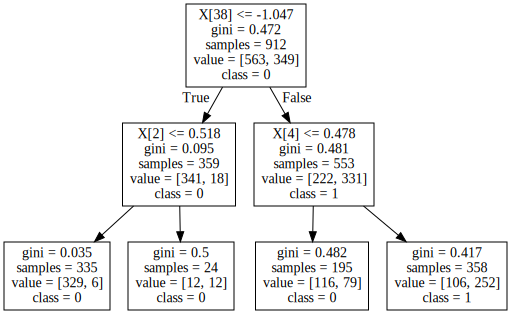

In [18]:
import graphviz
dot_data = tree.export_graphviz(tree_model, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph

Save it as .png:

In [19]:
import pydot
(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('decision_tree_timestamp.png')

### Random Forest with CV

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
parameters = {'max_depth':range(1,20), 'n_estimators':range(1,30)}
grid_model = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=4)
grid_model.fit(X=X_train_flat, y=Y_train)
forest_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)

0.7620728997778178 {'max_depth': 2, 'n_estimators': 6}


In [22]:
forest_model.score(X_test_flat, Y_test)

0.6140350877192983

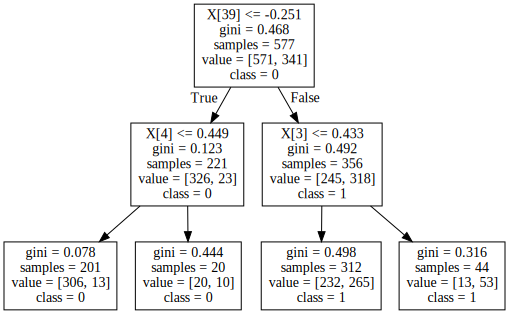

In [23]:
estimator = forest_model.estimators_[0]
dot_data = tree.export_graphviz(estimator, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph

Save it as .png:

In [24]:
(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('random_forest_0_timestamp.png')

Plot importances:

Feature ranking:
1. feature 39 (0.329468)
2. feature 38 (0.294619)
3. feature 4 (0.152184)
4. feature 24 (0.141857)
5. feature 6 (0.025211)
6. feature 3 (0.024238)
7. feature 36 (0.015906)
8. feature 8 (0.009665)
9. feature 1 (0.003837)
10. feature 16 (0.003015)
11. feature 7 (0.000000)
12. feature 17 (0.000000)
13. feature 5 (0.000000)
14. feature 10 (0.000000)
15. feature 11 (0.000000)
16. feature 12 (0.000000)
17. feature 2 (0.000000)
18. feature 13 (0.000000)
19. feature 14 (0.000000)
20. feature 15 (0.000000)
21. feature 9 (0.000000)
22. feature 19 (0.000000)
23. feature 18 (0.000000)
24. feature 20 (0.000000)
25. feature 37 (0.000000)
26. feature 35 (0.000000)
27. feature 34 (0.000000)
28. feature 33 (0.000000)
29. feature 32 (0.000000)
30. feature 31 (0.000000)
31. feature 30 (0.000000)
32. feature 29 (0.000000)
33. feature 28 (0.000000)
34. feature 27 (0.000000)
35. feature 26 (0.000000)
36. feature 25 (0.000000)
37. feature 23 (0.000000)
38. feature 22 (0.000000)
39. feature 2

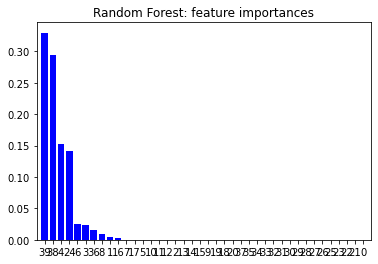

In [37]:
import matplotlib.pyplot as plt
importances = forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_flat.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Random Forest: feature importances")
plt.bar(range(X_train_flat.shape[1]), importances[indices],
        color="blue", align="center")
plt.xticks(range(X_train_flat.shape[1]), indices)
plt.xlim([-1, X_train_flat.shape[1]])
plt.savefig('random_forest_importance_timestamp.png')
plt.show()

What we've obtained so far are very similar to the case without timestamp information, this implies that these additional information didn't help to improve the models.

### Gradient Boost Model with CV

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
parameters = {'max_depth':range(2,10), 'learning_rate':[0.1,0.01, 1e-3]}
grid_model = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=4)
grid_model.fit(X=X_train_flat, y=Y_train)
GB_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)

0.7412778478352249 {'learning_rate': 0.01, 'max_depth': 3}


In [12]:
GB_model.score(X_test_flat, Y_test)

0.5964912280701754

In [13]:
print('N trees: ', GB_model.n_estimators_)

N trees:  100


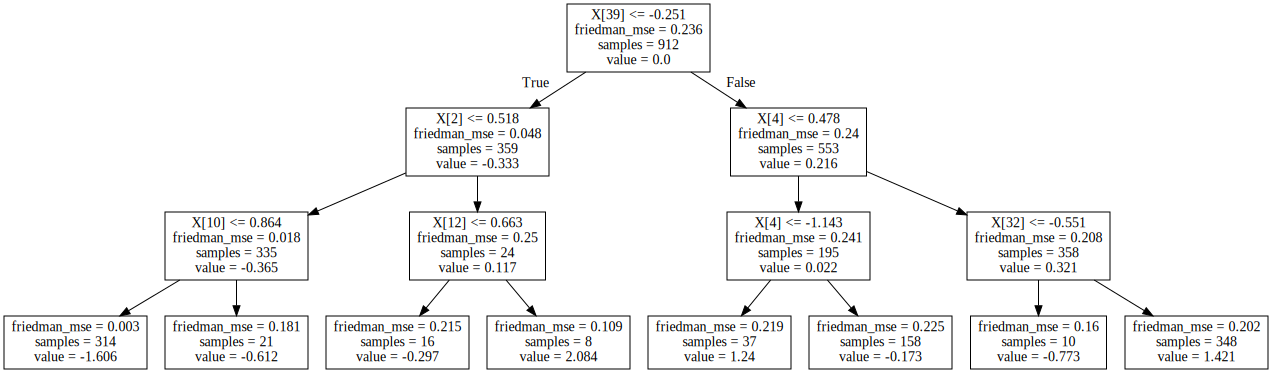

In [18]:
estimator = GB_model.estimators_[0,0]
dot_data = tree.export_graphviz(estimator, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph

Save it as .png:

In [21]:
(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('GB_0_timestamp.png')

Plot importances:

Feature ranking:
1. feature 36 (0.290678)
2. feature 39 (0.160544)
3. feature 32 (0.142681)
4. feature 4 (0.134465)
5. feature 38 (0.087071)
6. feature 2 (0.042810)
7. feature 30 (0.040841)
8. feature 24 (0.017909)
9. feature 12 (0.011174)
10. feature 20 (0.007773)
11. feature 6 (0.007156)
12. feature 0 (0.006556)
13. feature 17 (0.005084)
14. feature 1 (0.004722)
15. feature 8 (0.004493)
16. feature 19 (0.004314)
17. feature 10 (0.003413)
18. feature 3 (0.003401)
19. feature 14 (0.003297)
20. feature 26 (0.002884)
21. feature 31 (0.002812)
22. feature 22 (0.002715)
23. feature 27 (0.002440)
24. feature 13 (0.002086)
25. feature 15 (0.002066)
26. feature 25 (0.001863)
27. feature 35 (0.001828)
28. feature 11 (0.000984)
29. feature 9 (0.000935)
30. feature 18 (0.000362)
31. feature 16 (0.000347)
32. feature 21 (0.000102)
33. feature 5 (0.000098)
34. feature 7 (0.000094)
35. feature 29 (0.000001)
36. feature 28 (0.000001)
37. feature 34 (0.000000)
38. feature 33 (0.000000)
39. feature 37

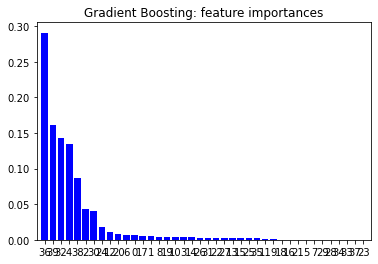

In [24]:
importances = GB_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_flat.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Gradient Boosting: feature importances")
plt.bar(range(X_train_flat.shape[1]), importances[indices],
        color="blue", align="center")
plt.xticks(range(X_train_flat.shape[1]), indices)
plt.xlim([-1, X_train_flat.shape[1]])
plt.savefig('GB_importance_timestamp.png')
plt.show()

### DL models: MLP and RNNs with GRID search

In [38]:
import tensorflow as tf

### MLP

In [39]:
def build_fc_model(n_units=30, learning_rate=1e-3, regularizer='l2'):
    model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(n_units, activation="relu", kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(n_units, activation="relu", kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizer)
                                     ]) 
    model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return model

keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fc_model)

In [40]:
param_distribs = {
    "n_units": [80, 100],
    "learning_rate": [1e-3, 1e-4],
    "regularizer": ['l1','l2']}

In [41]:
grid_search = GridSearchCV(keras_reg, param_distribs)

In [42]:
grid_search.fit(X_train_flat, Y_train, epochs=100, shuffle=True, batch_size=128, verbose=0)

6/6 [==============================] - 0s 901us/step - loss: 1.2807 - accuracy: 0.7582


GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb38978dc70>,
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.0001], 'n_units': [80, 100],
                         'regularizer': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [43]:
print('Hyperparameters: ', grid_search.best_params_)

Hyperparameters:  {'learning_rate': 0.001, 'n_units': 80, 'regularizer': 'l2'}


In [46]:
fc_model = build_fc_model(80, 1e-3, 'l2')
fc_model.fit(X_train_flat, Y_train, epochs=100, shuffle=True, batch_size=128, verbose=0)

fc_model_pred = fc_model.predict(X_train_flat)
print('Training accuracy: ', np.mean((fc_model_pred>=0.5).squeeze().astype(int) == Y_train))
fc_model_pred = fc_model.predict(X_test_flat)
print('Test accuracy: ', np.mean((fc_model_pred>=0.5).squeeze().astype(int) == Y_test))

Training accuracy:  0.7883771929824561
Test accuracy:  0.6052631578947368


In [48]:
fc_model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 80)                3280      
_________________________________________________________________
dense_130 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 81        
Total params: 9,841
Trainable params: 9,841
Non-trainable params: 0
_________________________________________________________________


### RNN with LSTM

In [49]:
def build_lstm_model(n_lstm=4 ,n_units=50, learning_rate=1e-3):
    lstm_model = tf.keras.models.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(n_lstm, return_sequences=True))
    lstm_model.add(tf.keras.layers.LSTM(n_lstm))
    lstm_model.add(tf.keras.layers.Dense(n_units, activation='relu', kernel_regularizer='l2'))
    lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2'))
    
    lstm_model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return lstm_model

In [50]:
param_distribs = {
    "n_lstm": [4, 10],
    "n_units": [30, 60],
    "learning_rate": [1e-2, 1e-3]}
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_lstm_model)
grid_search = GridSearchCV(keras_reg, param_distribs)

In [52]:
grid_search = GridSearchCV(keras_reg, param_distribs)
grid_search.fit(X_train, Y_train, epochs=80, batch_size=128, shuffle=True, verbose=0)
print('Hyperparameters: ', grid_search.best_params_)

6/6 [==============================] - 0s 4ms/step - loss: 0.5410 - accuracy: 0.7418
Hyperparameters:  {'learning_rate': 0.01, 'n_lstm': 4, 'n_units': 30}


In [55]:
lstm_model = build_lstm_model(4, 30, 1e-2)
lstm_model.fit(X_train, Y_train, epochs=80, batch_size=128, shuffle=True, verbose=0)

lstm_model_pred = lstm_model.predict(X_train)
print('Training accuracy: ', np.mean((lstm_model_pred>=0.5).squeeze().astype(int) == Y_train))
lstm_model_pred = lstm_model.predict(X_test)
print('Test accuracy: ', np.mean((lstm_model_pred>=0.5).squeeze().astype(int) == Y_test))

Training accuracy:  0.7927631578947368
Test accuracy:  0.6096491228070176


In [56]:
lstm_model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_166 (LSTM)              (None, 20, 4)             112       
_________________________________________________________________
lstm_167 (LSTM)              (None, 4)                 144       
_________________________________________________________________
dense_298 (Dense)            (None, 30)                150       
_________________________________________________________________
dense_299 (Dense)            (None, 1)                 31        
Total params: 437
Trainable params: 437
Non-trainable params: 0
_________________________________________________________________


### Bidirectional RNN with LSTMs with GRID search

In [7]:
def build_bidir_model(n_lstm=4 ,n_units=30, learning_rate=1e-3):
    bidir_model = tf.keras.models.Sequential()
    bidir_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_lstm)))
    bidir_model.add(tf.keras.layers.Dense(n_units, activation='relu',kernel_regularizer='l2'))
    bidir_model.add(tf.keras.layers.Dense(n_units, activation='relu',kernel_regularizer='l2'))
    bidir_model.add(tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer='l2'))
    
    bidir_model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return bidir_model

In [10]:
param_distribs = {
    "n_lstm": [10,16],
    "n_units": [60,100],
    "learning_rate": [1e-2, 1e-3]}
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_bidir_model)

grid_search = GridSearchCV(keras_reg, param_distribs)
grid_search.fit(X_train, Y_train, epochs=80, verbose=0)
print('Hyperparameters: ', grid_search.best_params_)

6/6 [==============================] - 0s 2ms/step - loss: 0.5338 - accuracy: 0.7582
Hyperparameters:  {'learning_rate': 0.001, 'n_lstm': 10, 'n_units': 60}


In [13]:
bidir_model = build_bidir_model(10, 60, 1e-3)
bidir_model.fit(X_train, Y_train, epochs=80, batch_size=128, shuffle=True, verbose=0)

bidir_model_pred = bidir_model.predict(X_train)
print('Training accuracy: ', np.mean((bidir_model_pred>=0.5).squeeze().astype(int) == Y_train))
bidir_model_pred = bidir_model.predict(X_test)
print('Test accuracy: ', np.mean((bidir_model_pred>=0.5).squeeze().astype(int) == Y_test))

Training accuracy:  0.7379385964912281
Test accuracy:  0.6140350877192983


In [14]:
bidir_model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_42 (Bidirectio (None, 20)                1040      
_________________________________________________________________
dense_126 (Dense)            (None, 60)                1260      
_________________________________________________________________
dense_127 (Dense)            (None, 60)                3660      
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 61        
Total params: 6,021
Trainable params: 6,021
Non-trainable params: 0
_________________________________________________________________
